## Analyzing the sentiment of restaurant reviews to determine whether the feedback is positive, negative, or neutral using natural language processing techniques.

## Installing required Packages

In [1]:
!pip install contractions
!pip install emoji
!pip install beautifulsoup4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 2.5 MB/s eta 0:00:00


## Importing the libraries

In [2]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import emoji
import contractions
import re

## Downloading packages from nltk

In [3]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Importing Libraries

In [4]:
from collections import Counter
from wordcloud import WordCloud

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from bs4 import BeautifulSoup

In [6]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report

# Reading the dataset

In [9]:
data = pd.read_csv('Reviews.csv')
data.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [10]:
value_counts = data['Liked'].value_counts()
value_counts

,count
Liked,
1,500
0,500


# Value Count Plot

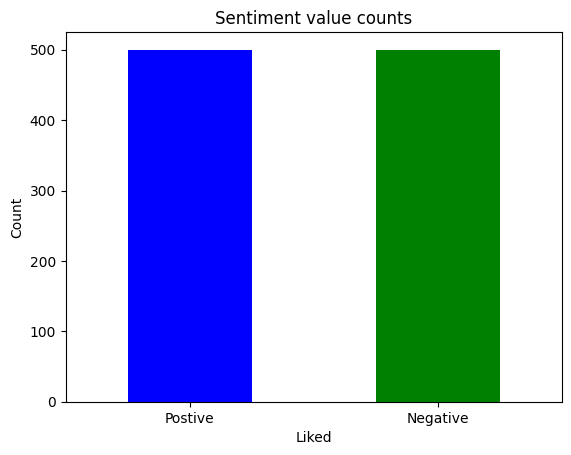

In [11]:
value_counts.plot(kind = 'bar' , color = ['blue', 'green'])
plt.title("Sentiment value counts")
plt.xlabel('Liked')
plt.ylabel('Count')
plt.xticks(ticks=[0,1] , labels=['Postive','Negative'],rotation=0)
plt.show()

# WordCloud

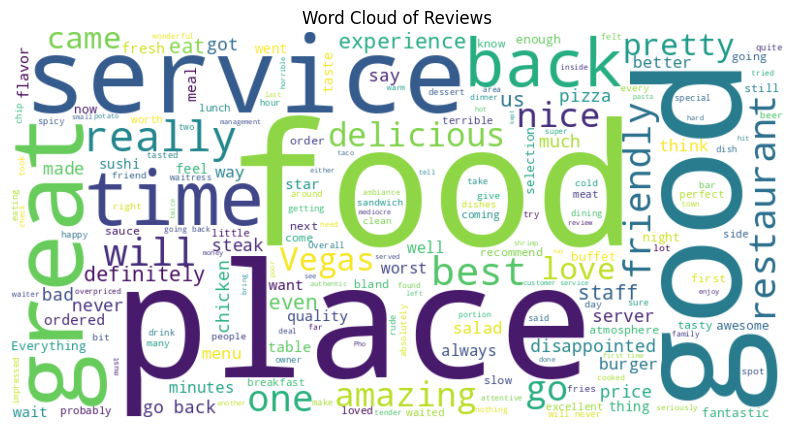

In [12]:
combined_text = " ".join(data['Review'])
wordcloud = WordCloud(width = 800 , height = 400 ,background_color = 'white').generate(combined_text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()

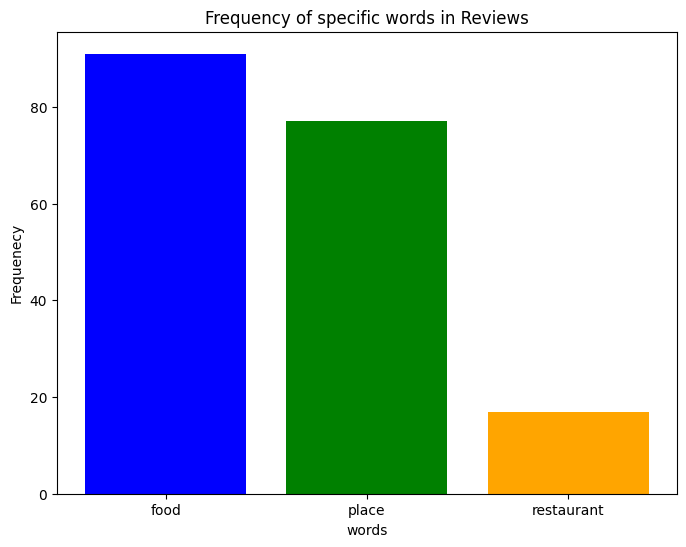

In [13]:
target_words = ['food','place','restaurant']
all_words = " ".join(data['Review']).lower().split()
word_counts = Counter(all_words)
target_word_counts = {word:word_counts[word] for word in target_words}
plt.figure(figsize=(8,6))
plt.bar(target_word_counts.keys(),target_word_counts.values() , color = ['blue','green','orange'])
plt.xlabel('words')
plt.ylabel('Frequenecy')
plt.title('Frequency of specific words in Reviews')
plt.show()

In [14]:
data['Review'] = data['Review'].str.lower()
data['Review']

,Review
0,wow... loved this place.
1,crust is not good.
2,not tasty and the texture was just nasty.
3,stopped by during the late may bank holiday of...
4,the selection on the menu was great and so wer...
...,...
995,i think food should have flavor and texture an...
996,appetite instantly gone.
997,overall i was not impressed and would not go b...
998,"the whole experience was underwhelming, and i ..."


# Tokenization

In [15]:
data['Tokens'] = data['Review'].apply(word_tokenize)
data['Tokens']

,Tokens
0,"[wow, ..., loved, this, place, .]"
1,"[crust, is, not, good, .]"
2,"[not, tasty, and, the, texture, was, just, nas..."
3,"[stopped, by, during, the, late, may, bank, ho..."
4,"[the, selection, on, the, menu, was, great, an..."
...,...
995,"[i, think, food, should, have, flavor, and, te..."
996,"[appetite, instantly, gone, .]"
997,"[overall, i, was, not, impressed, and, would, ..."
998,"[the, whole, experience, was, underwhelming, ,..."


In [16]:
data['Review'] = data['Review'].str.replace(f"[{string.punctuation}]"," ",regex = True)
data['Review']

,Review
0,wow loved this place
1,crust is not good
2,not tasty and the texture was just nasty
3,stopped by during the late may bank holiday of...
4,the selection on the menu was great and so wer...
...,...
995,i think food should have flavor and texture an...
996,appetite instantly gone
997,overall i was not impressed and would not go b...
998,the whole experience was underwhelming and i ...


# Removing Stop Words

In [17]:
stop_words = set(stopwords.words('english'))

In [18]:
data['Tokens'] = data['Review'].apply(lambda x: [word for word in word_tokenize(x) if word not in stop_words])
data['Tokens']

,Tokens
0,"[wow, loved, place]"
1,"[crust, good]"
2,"[tasty, texture, nasty]"
3,"[stopped, late, may, bank, holiday, rick, stev..."
4,"[selection, menu, great, prices]"
...,...
995,"[think, food, flavor, texture, lacking]"
996,"[appetite, instantly, gone]"
997,"[overall, impressed, would, go, back]"
998,"[whole, experience, underwhelming, think, go, ..."


# Stemming

In [19]:
stemmer = PorterStemmer()
data['stemmed'] = data['Review'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
data['stemmed']

,stemmed
0,wow love thi place
1,crust is not good
2,not tasti and the textur wa just nasti
3,stop by dure the late may bank holiday off ric...
4,the select on the menu wa great and so were th...
...,...
995,i think food should have flavor and textur and...
996,appetit instantli gone
997,overal i wa not impress and would not go back
998,the whole experi wa underwhelm and i think we ...


# Lemmatization

In [20]:
lemmatizer = WordNetLemmatizer()

In [21]:
data['Lemmatized'] = data['Review'].apply(lambda x :' '.join([lemmatizer.lemmatize(word , pos = wordnet.VERB) for word in word_tokenize(x)]))
data['Lemmatized']

,Lemmatized
0,wow love this place
1,crust be not good
2,not tasty and the texture be just nasty
3,stop by during the late may bank holiday off r...
4,the selection on the menu be great and so be t...
...,...
995,i think food should have flavor and texture an...
996,appetite instantly go
997,overall i be not impress and would not go back
998,the whole experience be underwhelming and i th...


In [22]:
data['No_Numbers'] = data['Review'].apply(lambda x : re.sub(r'\d+',' ' ,x))
data['No_Numbers']

,No_Numbers
0,wow loved this place
1,crust is not good
2,not tasty and the texture was just nasty
3,stopped by during the late may bank holiday of...
4,the selection on the menu was great and so wer...
...,...
995,i think food should have flavor and texture an...
996,appetite instantly gone
997,overall i was not impressed and would not go b...
998,the whole experience was underwhelming and i ...


In [23]:
data['cleaned'] = data['Review'].apply(lambda x: re.sub(r'[^A-Za-z0-9\s]','' ,x))
data['cleaned']

,cleaned
0,wow loved this place
1,crust is not good
2,not tasty and the texture was just nasty
3,stopped by during the late may bank holiday of...
4,the selection on the menu was great and so wer...
...,...
995,i think food should have flavor and texture an...
996,appetite instantly gone
997,overall i was not impressed and would not go b...
998,the whole experience was underwhelming and i ...


In [24]:
data['Expanded'] = data['Review'].apply(contractions.fix)
data['Expanded']

,Expanded
0,wow loved this place
1,crust is not good
2,not tasty and the texture was just nasty
3,stopped by during the late may bank holiday of...
4,the selection on the menu was great and so wer...
...,...
995,i think food should have flavor and texture an...
996,appetite instantly gone
997,overall i was not impressed and would not go b...
998,the whole experience was underwhelming and i ...


# Removing Emoji's

In [25]:
data['emoji'] = data['Review'].apply(emoji.demojize)
data['emoji']

,emoji
0,wow loved this place
1,crust is not good
2,not tasty and the texture was just nasty
3,stopped by during the late may bank holiday of...
4,the selection on the menu was great and so wer...
...,...
995,i think food should have flavor and texture an...
996,appetite instantly gone
997,overall i was not impressed and would not go b...
998,the whole experience was underwhelming and i ...


In [26]:
data['cleaned'] = data['Review'].apply(lambda x: BeautifulSoup(x,"html.parser").get_text())
data['cleaned']

,cleaned
0,wow loved this place
1,crust is not good
2,not tasty and the texture was just nasty
3,stopped by during the late may bank holiday of...
4,the selection on the menu was great and so wer...
...,...
995,i think food should have flavor and texture an...
996,appetite instantly gone
997,overall i was not impressed and would not go b...
998,the whole experience was underwhelming and i ...


# Vectorizing the Text

In [27]:
vectorizer = TfidfVectorizer()

In [28]:
X = vectorizer.fit_transform(data['Review'])
print(X.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [29]:
X = vectorizer.fit_transform(data['Review'])
y = data['Liked']

# Splitting the dataset into training and testing

In [30]:
X_train,X_test,y_train,y_test = train_test_split(X,y , test_size = 0.2 , random_state = 42)

# Loading and training the model

In [31]:
model = MultinomialNB()
model.fit(X_train,y_train)

MultinomialNB()

# Testing the model

In [32]:
y_pred = model.predict(X_test)

# Accuracy and Report

In [33]:
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy:",accuracy)

Accuracy: 0.8


In [34]:
report = classification_report(y_test,y_pred)
print("Report:",report)

Report:               precision    recall  f1-score   support

           0       0.76      0.85      0.80        96
           1       0.85      0.75      0.80       104

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.80       200
weighted avg       0.81      0.80      0.80       200



## Prediction on a new Review

In [35]:
#preprocessing of new review
def preprocess_review(review):
    review = review.lower()
    review = BeautifulSoup(review,"html.parser").get_text()
    review = re.sub(f"[{string.punctuation}]"," ",review)
    review = contractions.fix(review)
    review = emoji.demojize(review)
    tokens = word_tokenize(review)
    stop_words =set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word, pos = 'v') for word in tokens]
    cleaned_review = ' '.join(lemmatized_tokens)
    return cleaned_review

In [36]:
#new review prediction
new_review = input("Enter a review: ")
cleaned_review = preprocess_review(new_review)
new_review_vectorized = vectorizer.transform([cleaned_review])
prediction = model.predict(new_review_vectorized)
if prediction[0] == 1:
    print("The review is predicted postive")
else:
    print("The review is predicted negative")

Enter a review: the food is good
The review is predicted postive
